# Лабораторная работа 6

## Анализ и прогнозирование временного ряда.

Цель лабораторной работы: изучение основных методов анализа и прогнозирование временных рядов.


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.express as px
import plotly.figure_factory as ff
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, plot_roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score

from datetime import date


import statsmodels.api as sm




from matplotlib import pyplot
import matplotlib.pyplot as plt

# скроем предупреждения о возможных ошибках для лучшей читаемости
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('bitcoins.csv')

In [ ]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [ ]:
data.shape

(2713, 7)

In [ ]:
selected_columns = data[["Date","Open"]]

new_df = selected_columns.copy()

print(new_df)

            Date          Open
0     2014-09-17    465.864014
1     2014-09-18    456.859985
2     2014-09-19    424.102997
3     2014-09-20    394.673004
4     2014-09-21    408.084991
...          ...           ...
2708  2022-02-15  42586.464844
2709  2022-02-16  44578.277344
2710  2022-02-17  43937.070313
2711  2022-02-18  40552.132813
2712  2022-02-19  40022.132813

[2713 rows x 2 columns]


In [ ]:
data = new_df[data['Open'].notna()]

In [ ]:
print(new_df)

            Date          Open
0     2014-09-17    465.864014
1     2014-09-18    456.859985
2     2014-09-19    424.102997
3     2014-09-20    394.673004
4     2014-09-21    408.084991
...          ...           ...
2708  2022-02-15  42586.464844
2709  2022-02-16  44578.277344
2710  2022-02-17  43937.070313
2711  2022-02-18  40552.132813
2712  2022-02-19  40022.132813

[2713 rows x 2 columns]


In [ ]:
data.isnull().sum()

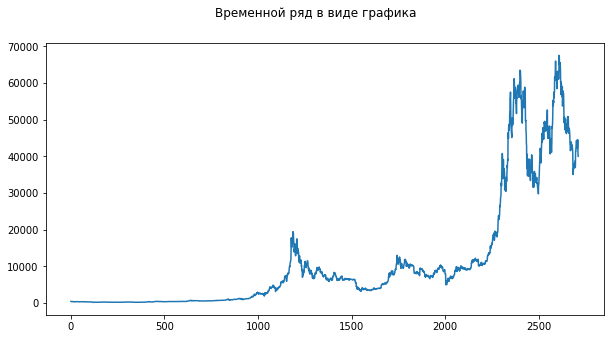

In [ ]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle("Временной ряд в виде графика")
data.plot(ax=ax, legend=False)
pyplot.show()

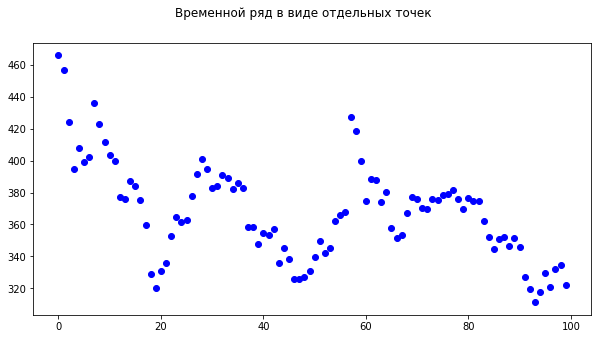

In [ ]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Временной ряд в виде отдельных точек')
data[:100].plot(ax=ax, legend=False, style='bo')
pyplot.show()

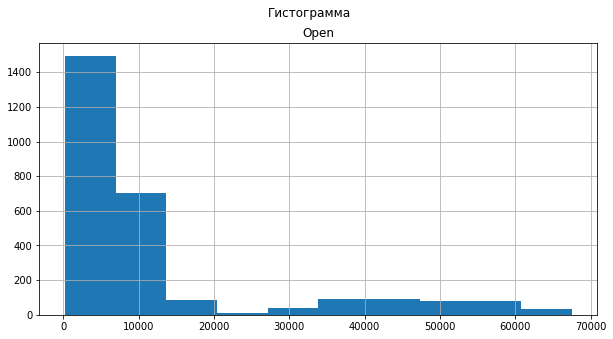

In [ ]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Гистограмма')
data.hist(ax=ax, legend=False)
pyplot.show()

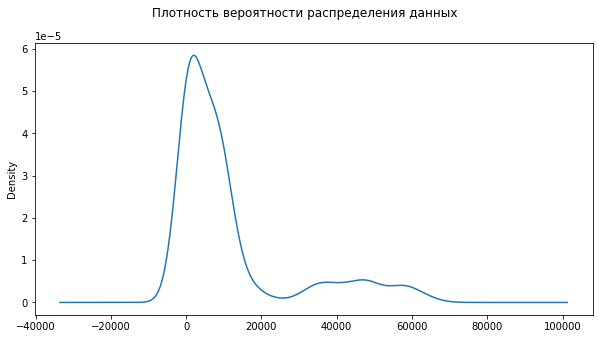

In [ ]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Плотность вероятности распределения данных')
data.plot(ax=ax, kind='kde', legend=False)
pyplot.show()

In [ ]:
data.shape

(2713, 2)

In [ ]:
data_open = data[["Open"]]

data_open = data_open.copy()

data_open.shape

(2713, 1)

## Lag Plots

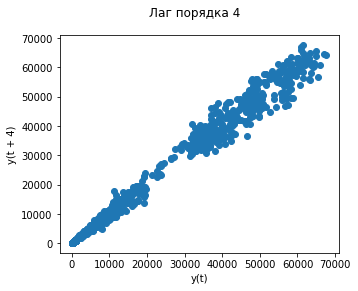

In [ ]:
for i in range(1, 5):
    fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(5,4))
    fig.suptitle(f'Лаг порядка {i}')
    pd.plotting.lag_plot(data_open, lag=i, ax=ax)
    pyplot.show()

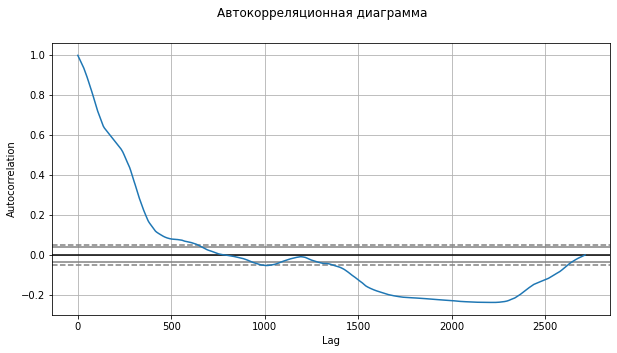

In [ ]:
# По оси Y откладывается ковариация 

fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Автокорреляционная диаграмма')
pd.plotting.autocorrelation_plot(data_open, ax=ax)
pyplot.show()

## Автокорреляционная функция

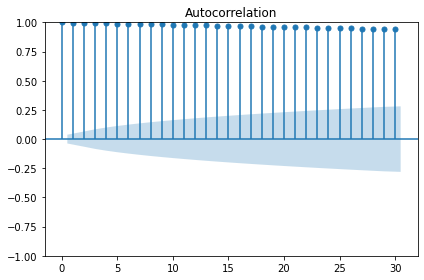

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data_open, lags=30)
plt.tight_layout()

## Частичная автокорреляционная функция

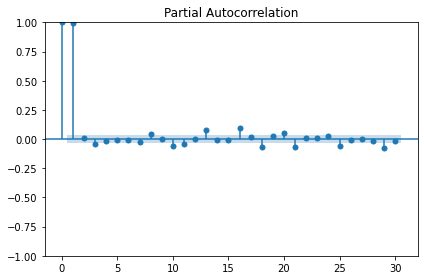

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data_open, lags=30)
plt.tight_layout()

## Декомпозиция временного ряда с помощью библиотеки statsmodels

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Аддитивная модель
def plot_decompose(data=data['Open'], model='add'):
    result_add = seasonal_decompose(data, model = 'add', period = 1)
    fig = result_add.plot()
    fig.set_size_inches((10, 8))
    # Перерисовка
    fig.tight_layout()
    plt.show()

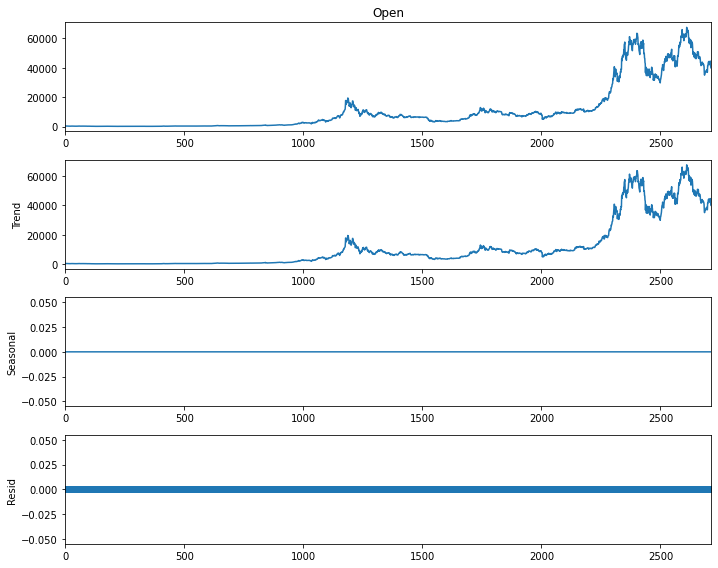

In [ ]:
plot_decompose(data=data_open['Open'], model='add')

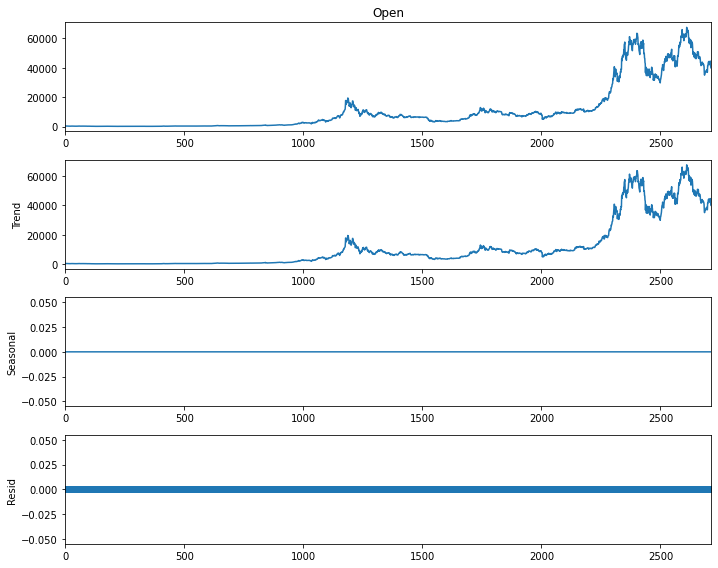

In [ ]:
plot_decompose(data=data['Open'], model='mul')

## Скользящая средняя

In [ ]:
ts_fb2 = data.copy()

In [ ]:
# Простое скользящее среднее (SMA)
ts_fb2['SMA_10'] = ts_fb2['Open'].rolling(10, min_periods=1).mean()
ts_fb2['SMA_20'] = ts_fb2['Open'].rolling(20, min_periods=1).mean()

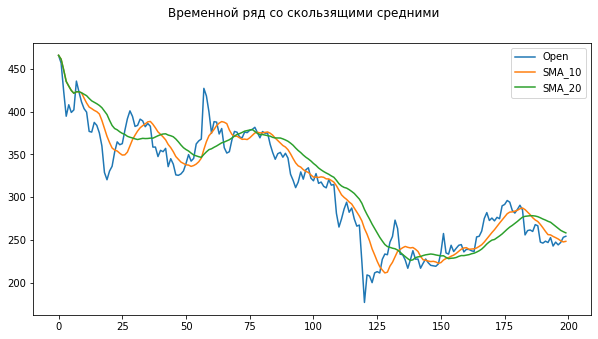

In [ ]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Временной ряд со скользящими средними')
ts_fb2[:200].plot(ax=ax, legend=True)
pyplot.show()

## Прогнозирование временного ряда авторегрессионными методами
Методы прогнозирования
1) Модель ARMA
2) Модель ARIMA
3) Модель Хольта-Винтера

Реализация методов прогнозирования

1) Статья с примерами прогнозирования на Python
2) Подбор гиперпараметров для модели ARIMA

In [ ]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
# Целочисленная метка шкалы времени 
xnum = list(range(ts_fb2.shape[0]))
# Разделение выборки на обучающую и тестовую
Y = ts_fb2['Open'].values
train_size = int(len(Y) * 0.7)
xnum_train, xnum_test = xnum[0:train_size], xnum[train_size:]
train, test = Y[0:train_size], Y[train_size:]
history_arima = [x for x in train]
history_es = [x for x in train]

In [ ]:
# Параметры модели (p,d,q) 
arima_order = (6,1,0)
# Формирование предсказаний
predictions_arima = list()
for t in range(len(test)):
    model_arima = ARIMA(history_arima, order=arima_order)
    model_arima_fit = model_arima.fit()
    yhat_arima = model_arima_fit.forecast()[0]
    predictions_arima.append(yhat_arima)
    history_arima.append(test[t])
# Вычисление метрики RMSE
error_arima = mean_squared_error(test, predictions_arima, squared=False)

In [ ]:
# Формирование предсказаний
predictions_es = list()
for t in range(len(test)):
    model_es = ExponentialSmoothing(history_es)
    model_es_fit = model_es.fit()
    yhat_es = model_es_fit.forecast()[0]
    predictions_es.append(yhat_es)
    history_es.append(test[t])
# Вычисление метрики RMSE
error_es = mean_squared_error(test, predictions_es, squared=False)

In [ ]:
# Ошибка прогноза
np.mean(Y), error_arima, error_es

(11311.04106888942, 1371.9747136904361, 1353.2104725557544)

In [ ]:
# Записываем предсказания в DataFrame
ts_fb2['predictions_ARIMA'] = (train_size * [np.NAN]) + list(predictions_arima)
ts_fb2['predictions_HWES'] = (train_size * [np.NAN]) + list(predictions_es)

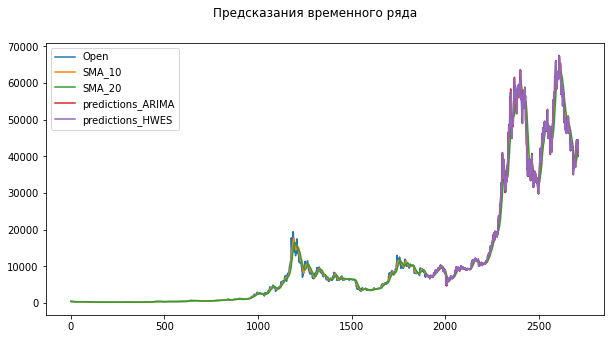

In [ ]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда')
ts_fb2.plot(ax=ax, legend=True)
pyplot.show()

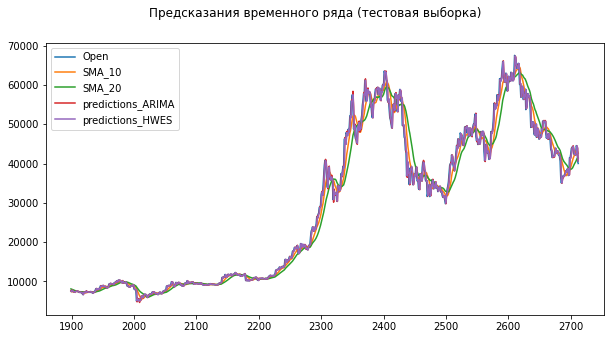

In [ ]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда (тестовая выборка)')
ts_fb2[train_size:].plot(ax=ax, legend=True)
pyplot.show()

Вывод. Предсказания ARIMA и HWES близки к скользящему среднему.